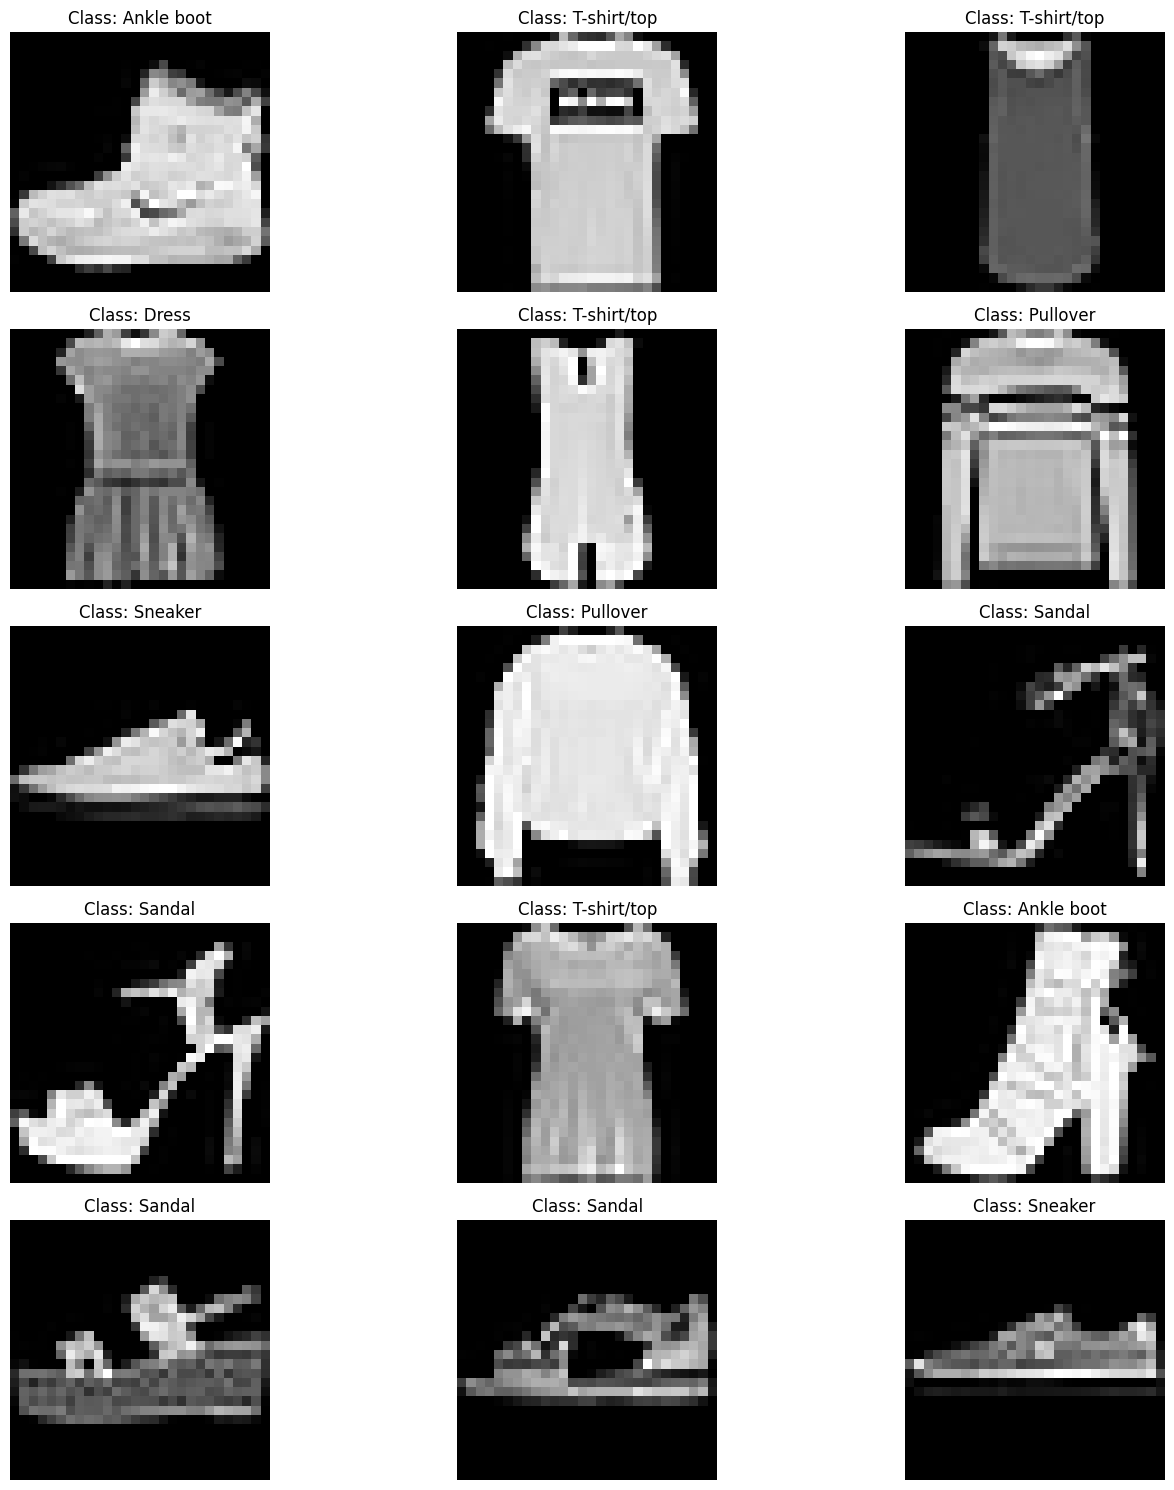

((60000, 784), (10000, 784), 10)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import adjusted_rand_score
from tensorflow.keras.models import Model
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split


# Load Fashion MNIST dataset
from keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Function to display images
def display_sample_images(images, labels, num_samples=15):
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        plt.subplot(5, 3, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Class: {class_nγξωξγφames[labels[i]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display some sample images
display_sample_images(train_images, train_labels)

(train_images_shape, test_images_shape, num_classes)







In [ ]:


# Reshape and normalize images
train_images = train_images.reshape((60000, 28 * 28)) / 255.0
test_images = test_images.reshape((10000, 28 * 28)) / 255.0


# Check the shape of the data
train_images_shape = train_images.shape
test_images_shape = test_images.shape
num_classes = len(np.unique(train_labels))

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming train_images and train_labels are already loaded and normalized

# Split the training data into training and validation sets
# test_size=0.2 means 20% of the data will be used for the validation set
# random_state is set to a fixed number for reproducibility of the results
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42)

# Check the shape of the resulting datasets
print("Training set images shape:", train_images.shape)
print("Validation set images shape:", val_images.shape)
print("Training set labels shape:", train_labels.shape)
print("Validation set labels shape:", val_labels.shape)

# Print the test set images and labels
print("Test set images shape:", test_images.shape)
print("Test set labels shape:", test_labels.shape)


Training set images shape: (48000, 784)
Validation set images shape: (12000, 784)
Training set labels shape: (48000,)
Validation set labels shape: (12000,)
Test set images shape: (10000, 784)
Test set labels shape: (10000,)


In [ ]:
# Function to perform dimensionality reduction using PCA or Stacked Autoencoder
def reduce_dimensionality(X_train, X_val, X_test, method='PCA', encoding_dim=None):
  if method == 'PCA':
      pca = PCA(n_components=encoding_dim)
      X_train_reduced = pca.fit_transform(X_train)
      X_val_reduced = pca.transform(X_val)
      X_test_reduced = pca.transform(X_test)
  elif method == 'SAE':
      # Stacked Autoencoder
      input_img = Input(shape=(784,))
      encoded = Dense(128, activation='relu')(input_img)
      encoded = Dense(64, activation='relu')(encoded)
      encoded = Dense(encoding_dim, activation='relu')(encoded)

      decoded = Dense(64, activation='relu')(encoded)
      decoded = Dense(128, activation='relu')(decoded)
      decoded = Dense(784, activation='sigmoid')(decoded)

      autoencoder = Model(input_img, decoded)
      encoder = Model(input_img, encoded)

      autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

      autoencoder.fit(X_train, X_train,
                      epochs=10,
                      batch_size=256,
                      shuffle=True,
                      validation_data=(X_val, X_val))

      X_train_reduced = encoder.predict(X_train)
      X_val_reduced = encoder.predict(X_val)
      X_test_reduced = encoder.predict(X_test)
  elif method == 't-SNE':
        tsne = TSNE(n_components=2, random_state=42)
        X_train_reduced = tsne.fit_transform(X_train)
        X_val_reduced = tsne.fit_transform(X_val)
        X_test_reduced = tsne.fit_transform(X_test)
  return X_train_reduced, X_val_reduced, X_test_reduced

# Function to perform clustering using MiniBatchKMeans or DBSCAN
def perform_clustering(X, method='MiniBatchKMeans', num_clusters=None):
  if method == 'MiniBatchKMeans':
      kmeans = MiniBatchKMeans(n_clusters=num_clusters, batch_size=100, random_state=42)
      clusters = kmeans.fit_predict(X)
  elif method == 'DBSCAN':
      dbscan = DBSCAN(eps=3, min_samples=5)
      clusters = dbscan.fit_predict(X)
  elif method == 'GMM':
      gmm = GaussianMixture(n_components=num_clusters, random_state=42)
      clusters = gmm.fit_predict(X)
  return clusters

# Function to evaluate clustering performance
def evaluate_clustering(X, clusters,test_labels):
  calinski_harabasz = calinski_harabasz_score(X, clusters)
  davies_bouldin = davies_bouldin_score(X, clusters)
  silhouette = silhouette_score(X, clusters)
  adjusted_rand = adjusted_rand_score(test_labels, clusters)

  return calinski_harabasz, davies_bouldin, silhouette, adjusted_rand

In [ ]:
# Initialize DataFrame to store results
results_df = pd.DataFrame(columns=['Dimensionality_Reduction_Method', 'Clustering_Method',
                                    'Training_Time', 'Execution_Time', 'Num_Clusters',
                                    'Calinski_Harabasz', 'Davies_Bouldin', 'Silhouette','Adjusted_Rand_Score'])

# Define parameters
dimensionality_reduction_methods = ['PCA', 'SAE', 't-SNE', 'Raw']
clustering_methods = ['MiniBatchKMeans', 'DBSCAN', 'GMM']
num_clusters = 10

# Iterate over dimensionality reduction methods
for dr_method in dimensionality_reduction_methods:
  if dr_method != 'Raw':
      # Apply dimensionality reduction
      start_time = time.time()
      train_images_reduced, val_images_reduced, test_images_reduced = reduce_dimensionality(train_images, val_images, test_images, method=dr_method, encoding_dim=32)
      training_time = time.time() - start_time
  else:
      # Use raw data
      train_images_reduced, val_images_reduced, test_images_reduced = train_images, val_images, test_images
      training_time = 0

  # Iterate over clustering methods
  for cl_method in clustering_methods:
      # Apply clustering
      start_time = time.time()
      clusters = perform_clustering(test_images_reduced, method=cl_method, num_clusters=num_clusters)
      execution_time = time.time() - start_time

      # Evaluate clustering performance
      calinski_harabasz, davies_bouldin, silhouette , adjusted_rand = evaluate_clustering(test_images_reduced, clusters,test_labels)

      # Store results in DataFrame
      results_df = results_df.append({
          'Dimensionality_Reduction_Method': dr_method,
          'Clustering_Method': cl_method,
          'Training_Time': training_time,
          'Execution_Time': execution_time,
          'Num_Clusters': num_clusters,
          'Calinski_Harabasz': calinski_harabasz,
          'Davies_Bouldin': davies_bouldin,
          'Silhouette': silhouette,
          'Adjusted_Rand_Score': adjusted_rand
      }, ignore_index=True)


# Save the results to a CSV file
csv_file_path = "clustering_results.csv"
results_df.to_csv(csv_file_path, index=False)

# Display the results
print(results_df)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-10-9f0f381fc245>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-10-9f0f381fc245>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-10-9f0f381fc245>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch 1/10
188/188 [==============================] - 7s 26ms/step - loss: 0.3923 - val_loss: 0.3250
Epoch 2/10
188/188 [==============================] - 3s 18ms/step - loss: 0.3145 - val_loss: 0.3079
Epoch 3/10
188/188 [==============================] - 3s 18ms/step - loss: 0.3048 - val_loss: 0.3029
Epoch 4/10
188/188 [==============================] - 5s 26ms/step - loss: 0.3001 - val_loss: 0.2983
Epoch 5/10
188/188 [==============================] - 3s 18ms/step - loss: 0.2969 - val_loss: 0.2956
Epoch 6/10
188/188 [==============================] - 3s 18ms/step - loss: 0.2945 - val_loss: 0.2935
Epoch 7/10
188/188 [==============================] - 4s 21ms/step - loss: 0.2924 - val_loss: 0.2916
Epoch 8/10
188/188 [==============================] - 4s 23ms/step - loss: 0.2907 - val_loss: 0.2900
Epoch 9/10
188/188 [==============================] - 3s 18ms/step - loss: 0.2891 - val_loss: 0.2888
Epoch 10/10
313/313 [==============================] - 1s 2ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-10-9f0f381fc245>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-10-9f0f381fc245>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
<ipython-input-10-9f0f381fc245>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Se

   Dimensionality_Reduction_Method Clustering_Method  Training_Time  \
0                              PCA   MiniBatchKMeans       8.243293   
1                              PCA            DBSCAN       8.243293   
2                              PCA               GMM       8.243293   
3                              SAE   MiniBatchKMeans      50.497862   
4                              SAE            DBSCAN      50.497862   
5                              SAE               GMM      50.497862   
6                            t-SNE   MiniBatchKMeans    1137.150983   
7                            t-SNE            DBSCAN    1137.150983   
8                            t-SNE               GMM    1137.150983   
9                              Raw   MiniBatchKMeans       0.000000   
10                             Raw            DBSCAN       0.000000   
11                             Raw               GMM       0.000000   

    Execution_Time Num_Clusters  Calinski_Harabasz  Davies_Bouldin  \
0     

<ipython-input-10-9f0f381fc245>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


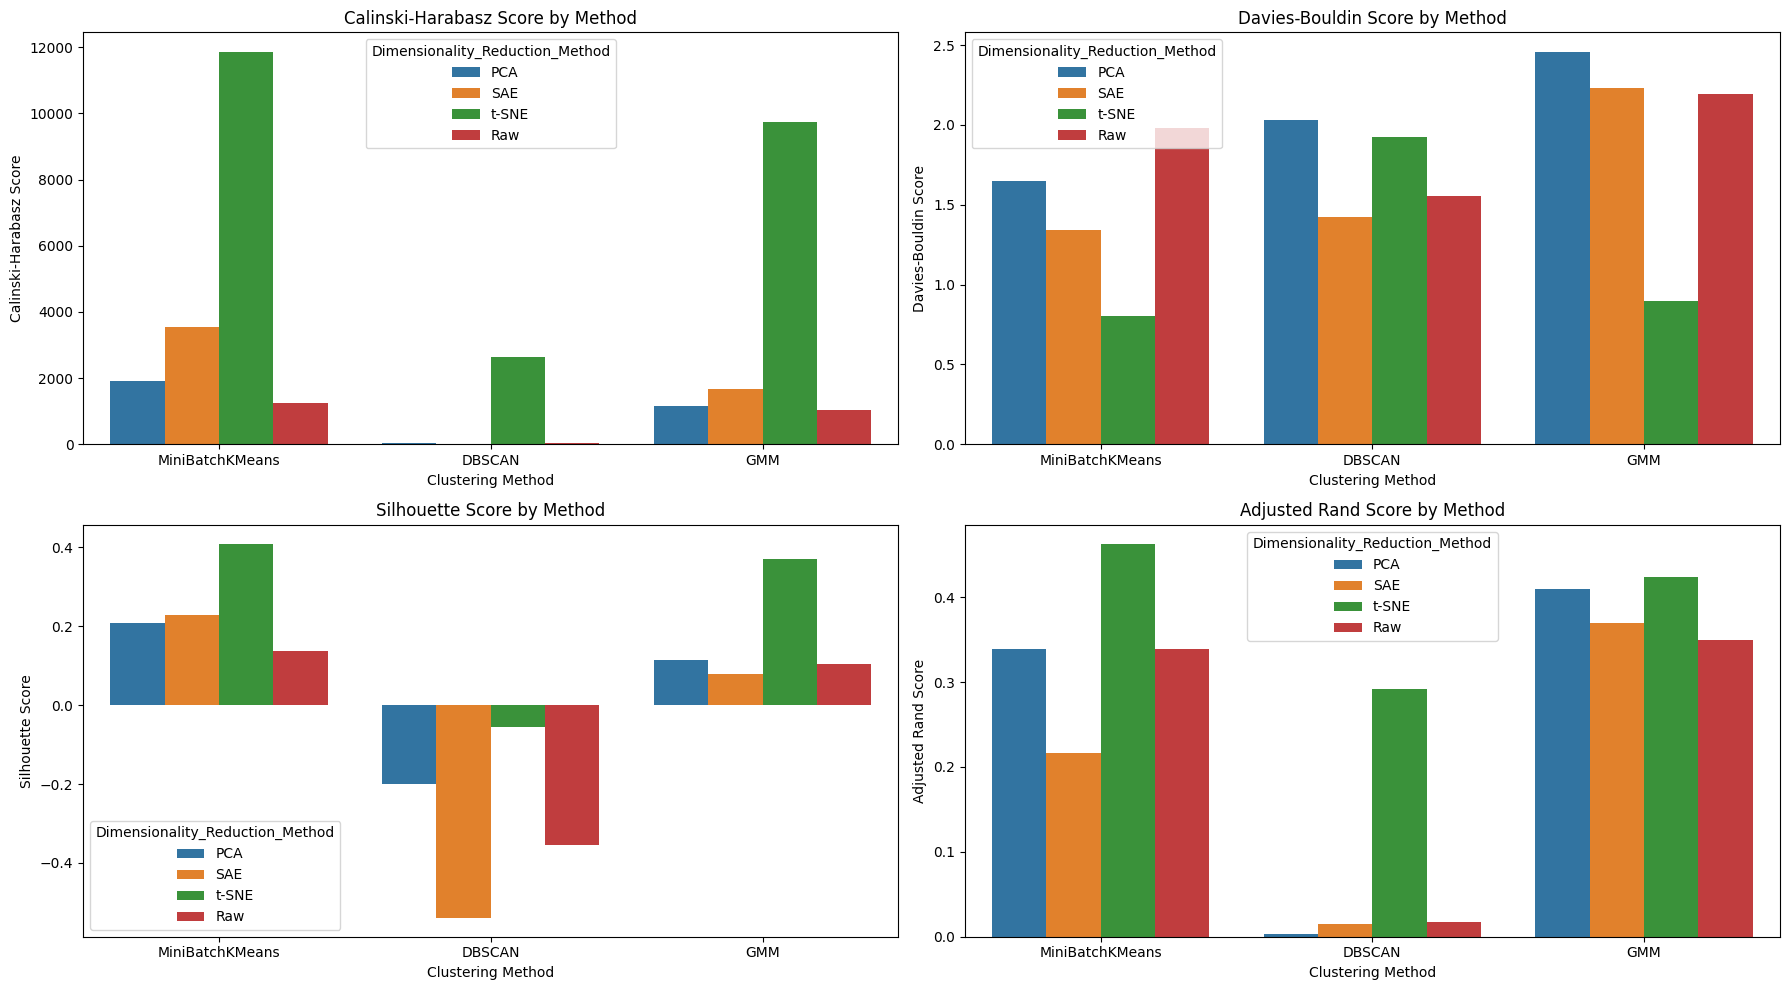

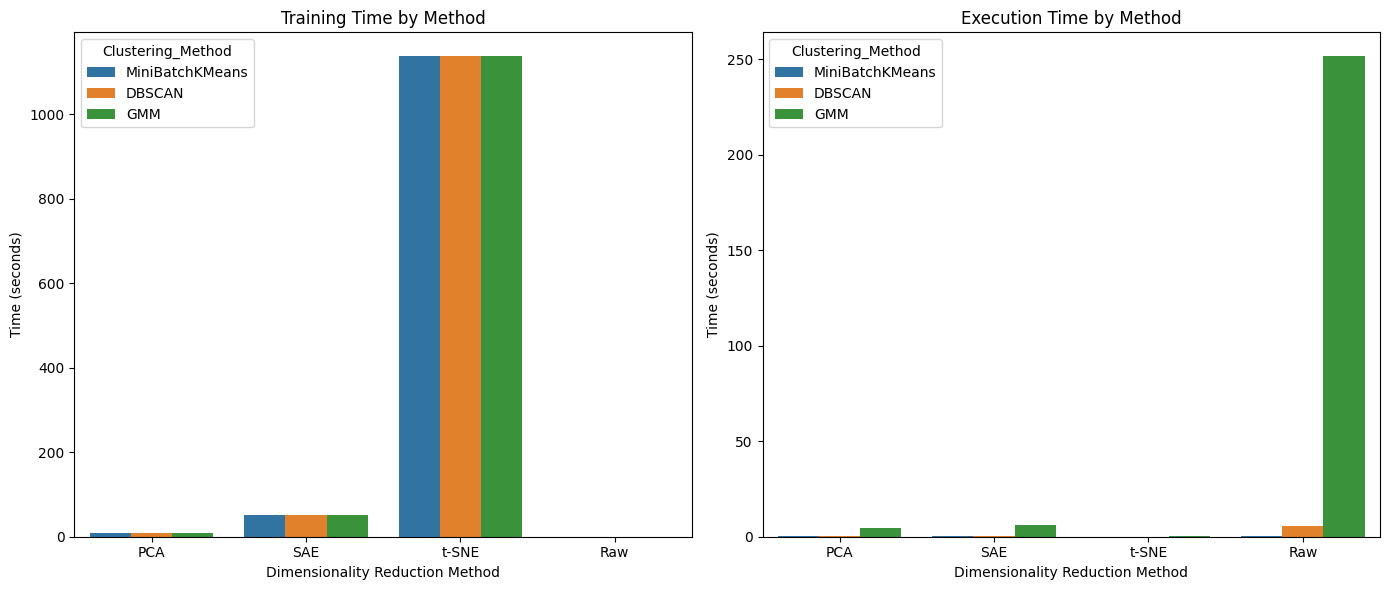

In [ ]:
import seaborn as sns
# Plotting Clustering Performance Metrics
plt.figure(figsize=(18, 10))

# Subplot for Calinski-Harabasz Score
plt.subplot(2, 2, 1)
sns.barplot(x='Clustering_Method', y='Calinski_Harabasz', hue='Dimensionality_Reduction_Method', data=results_df)
plt.title('Calinski-Harabasz Score by Method')
plt.ylabel('Calinski-Harabasz Score')
plt.xlabel('Clustering Method')

# Subplot for Davies-Bouldin Score
plt.subplot(2, 2, 2)
sns.barplot(x='Clustering_Method', y='Davies_Bouldin', hue='Dimensionality_Reduction_Method', data=results_df)
plt.title('Davies-Bouldin Score by Method')
plt.ylabel('Davies-Bouldin Score')
plt.xlabel('Clustering Method')

# Subplot for Silhouette Score
plt.subplot(2, 2, 3)
sns.barplot(x='Clustering_Method', y='Silhouette', hue='Dimensionality_Reduction_Method', data=results_df)
plt.title('Silhouette Score by Method')
plt.ylabel('Silhouette Score')
plt.xlabel('Clustering Method')

# Subplot for Adjusted Rand Score
plt.subplot(2, 2, 4)
sns.barplot(x='Clustering_Method', y='Adjusted_Rand_Score', hue='Dimensionality_Reduction_Method', data=results_df)
plt.title('Adjusted Rand Score by Method')
plt.ylabel('Adjusted Rand Score')
plt.xlabel('Clustering Method')

plt.tight_layout()
plt.show()

# Plot for Training and Execution Time
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Dimensionality_Reduction_Method', y='Training_Time', hue='Clustering_Method', data=results_df)
plt.title('Training Time by Method')
plt.ylabel('Time (seconds)')
plt.xlabel('Dimensionality Reduction Method')

plt.subplot(1, 2, 2)
sns.barplot(x='Dimensionality_Reduction_Method', y='Execution_Time', hue='Clustering_Method', data=results_df)
plt.title('Execution Time by Method')
plt.ylabel('Time (seconds)')
plt.xlabel('Dimensionality Reduction Method')

plt.tight_layout()
plt.show()
